## Cell 1: Import Libraries

In [1]:
"""
@author: Albert
"""
import sys
sys.path.append(".")
sys.path.append("..")

import numpy as np
import pandas as pd
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from Modules.Models import Models
import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.cuda.is_available()

True

## Cell 2: Initialising algorithm and required transformations

In [3]:
numberOfClasses = 8
pretrained = True
modelArchitecture = "densenet121"
net = Models(numberOfClasses = 9, pretrained = pretrained, model = modelArchitecture)
modelName = "Model/BestABIDLA2.pth.tar"
device = "cuda:0" if torch.cuda.is_available else "cpu" 
state = torch.load(modelName, map_location=device)
net.load_state_dict(state["model"])
device = torch.device(device)
net.to(device)
net.eval()

softmax = nn.Softmax()

transformCompose = transforms.Compose([ transforms.ToPILImage(),
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor()])

## Cell 3
### Please copy images to the Data folder and run the below cell to save ABIDLA2's predictions in Outputs folder.

Displaying ABIDLA predictions on first 5 images:


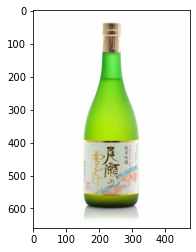

Image name:Sake.jpeg
Model predicts : Wine with a probability of 86.45 %
Model predicts : Champagnewith a probability of 9.82 %
Model predicts : Otherwith a probability of 3.52 %

Model Prediction is completed
Model Predicted 1 image(s) in 0.02 m and 0.92 seconds.
ABIDLA outputs can be found at Outputs/ABIDLA2Predictions.csv


In [4]:
classes = ["Beer Cup", "Beer Bottle", "Beer Can", 
           "Wine", "Champagne", "Undecided", "Other", "Cocktails", "Whiskey"]

imageDir = "./Data/"
# imageDir = "/media/albert/New Volume/Preprocessing Modules for Drinking Project/Scraping Data/RenamedImages/dataset/people drinking from beer can in asia"
listOfImages = os.listdir(imageDir)
listOfImages.sort(key=lambda x: x[:-4])
totalNumberOfImages = len(listOfImages)

t0 = time.time()

outputFilename = "Outputs/ABIDLA2Predictions.csv" #Output filename

if os.path.exists(outputFilename):
    print(f"Predictions file already exists in the \'{outputFilename}\'.")
    print(f"Please delete the existing {outputFilename} to rerun the code.")
    
else:
    with open(outputFilename,"w") as file:
        file.write(f"ImageName,ModelPrediction1,Probability1(%),ModelPrediction2,Probability2(%)")
        print(f"Displaying ABIDLA predictions on first 5 images:")
        
        for e, imageName in enumerate(listOfImages):
            originalImageName = imageName
            imageName = os.path.join(imageDir,imageName)
            image = Image.open(imageName).convert("RGB")
            if e < 10:
                plt.figure()
                imshow(image)
                plt.pause(0.0001)
            image = np.asarray(image)
            image = transformCompose(image)
            image = image[None, :, :,:]
            image = image.to(device)
            output = net(image)

            _, prediction =  torch.max(output,1)
            probabilities = softmax(output)

            top3Classes, indices = probabilities.topk(3)
            highestProbabilty, secondHighestProbability = top3Classes[0,0], top3Classes[0,1]
            thridHighestProbability = top3Classes[0,2]
            BestPrediction, SecondBestPrediction = classes[indices[0,0]], classes[indices[0,1]]
            ThirdBestPrediction = classes[indices[0,2]]
            file.write(f"\n{originalImageName},{BestPrediction},"
                       f"{str(round(float(highestProbabilty), 2)*100)},"
                       f"{SecondBestPrediction}, {str(round(float(secondHighestProbability), 2)*100)}")
            if e < 10:
                print(f"Image name:{originalImageName}")
                print(f"Model predicts : {BestPrediction} " 
                      f"with a probability of {str(round(float(highestProbabilty), 4)*100)} %")
                print(f"Model predicts : {SecondBestPrediction}" 
                      f"with a probability of {str(round(float(secondHighestProbability), 4)*100)} %")
                print(f"Model predicts : {ThirdBestPrediction}" 
                      f"with a probability of {str(round(float(thridHighestProbability), 4)*100)} %")

    t1 = time.time()
    totalTimeTaken = t1 - t0
    print(f"\nModel Prediction is completed")
    print(f"Model Predicted {len(listOfImages)} image(s) " 
          f"in {str(round(totalTimeTaken / 60, 2))} m and {str(round(totalTimeTaken % 60, 2))} seconds.")
    print(f"ABIDLA outputs can be found at {outputFilename}")

In [5]:
# Computing GPU performance
numberOfParameters = 0
for param in net.parameters():
    if param.requires_grad:
        numberOfParameters += param.numel()
print(f"Number of paramters = {numberOfParameters/1e6} Million")

Number of paramters = 6.963081 Million


In [6]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    numberOfParameters = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        numberOfParameters += params
    print(table)
    print(f"Total Trainable Params: {numberOfParameters}")
    return numberOfParameters
    
count_parameters(net)

+----------------------------------------------------+------------+
|                      Modules                       | Parameters |
+----------------------------------------------------+------------+
|             net.features.conv0.weight              |    9408    |
|             net.features.norm0.weight              |     64     |
|              net.features.norm0.bias               |     64     |
| net.features.denseblock1.denselayer1.norm1.weight  |     64     |
|  net.features.denseblock1.denselayer1.norm1.bias   |     64     |
| net.features.denseblock1.denselayer1.conv1.weight  |    8192    |
| net.features.denseblock1.denselayer1.norm2.weight  |    128     |
|  net.features.denseblock1.denselayer1.norm2.bias   |    128     |
| net.features.denseblock1.denselayer1.conv2.weight  |   36864    |
| net.features.denseblock1.denselayer2.norm1.weight  |     96     |
|  net.features.denseblock1.denselayer2.norm1.bias   |     96     |
| net.features.denseblock1.denselayer2.conv1.wei

6963081

In [7]:
!nvidia-smi

Fri Jun 23 12:21:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 18%   35C    P2    48W / 215W |   1175MiB /  7982MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())

216065536 217928192


In [13]:
from torch.profiler import profile, record_function, ProfilerActivity

In [30]:
torch.cuda.reset_accumulated_memory_stats()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
    net(image)

print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         4.98%       1.595ms         4.98%       1.595ms       2.641us       0.000us         0.00%       0.000us       0.000us           0 b           0 b     117.98 Mb     117.98 M

In [29]:
361600512, 398450176

(361600512, 398450176)